### Keyword Cluster Wordcloud
This notebook demonstrates keyword clustering and wordloud generation from fasttext word embeddings.

In [35]:
import pandas as pd
from wordcloud import WordCloud
import stanza
import fasttext as ft
import numpy as np
from tqdm.notebook import tqdm
from sklearn.cluster import AffinityPropagation
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
stanza.download("en")

In [2]:
# load data
df = pd.read_csv('res/bbc.csv')

In [3]:
df.label.unique()

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

In [4]:
sample = df[df.label == 'tech'].sample(10)

In [5]:
# load stanza
model_stanza = stanza.Pipeline(
    "en",
    processors="tokenize,pos,lemma",
    use_gpu=False,
    pos_batch_size=200,
    tokenize_pretokenized=False,
    logging_level="ERROR",
)

In [7]:
# get all tokens in the sample
raw = []
for text in tqdm(sample.text.values):
    doc = model_stanza(text)
    raw.extend([(word.pos, word.lemma) for sent in doc.sentences for word in sent.words])

In [8]:
# pick only certain POS
tokens = list(map(lambda x: x[1], filter(lambda x: x[0] in ['ADJ', 'NOUN', 'VERB'], set(raw))))

In [12]:
# load ft
model_ft = ft.load_model('C:/Users/Christian/Desktop/crawl-300d-2M-subword.bin')

In [13]:
# get embeddings
X = []
for t in tqdm(tokens):
    X.append(model_ft[t])

In [14]:
X = np.array(X)

In [17]:
# get cosine similarity for embeddings
similarities = cosine_similarity(X)

In [18]:
# cluster the tokens
af = AffinityPropagation(
    affinity="precomputed",
    random_state=42,
)
# Fit clusterer.
labels = af.fit_predict(similarities)

In [19]:
tokens = np.array(tokens)

In [25]:
# for each cluster, use centroid as label and 
# get distance from centroid for all tokens
ret = {}
for l, i in enumerate(af.cluster_centers_indices_):
    center = X[i]
    tok_center = tokens[i]
    members = X[af.labels_ == l]
    tok_members = tokens[af.labels_ == l]
    ret[tok_center] = {}
    for t, e in zip(tok_members, members):
        if not t == tok_center:
            ret[tok_center][t] = 1- cosine(center, e)

In [27]:
# reorganize the tokens
for k, v in ret.items():
    ret[k] = dict(sorted([(tok, dist) for tok, dist in v.items() if dist > 0], key=lambda x: x[1], reverse=True)[:20])

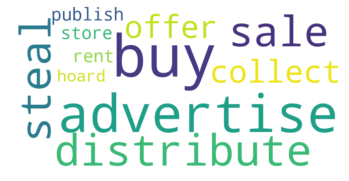

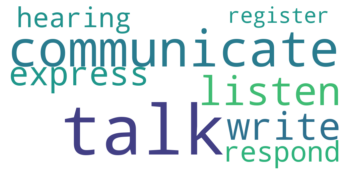

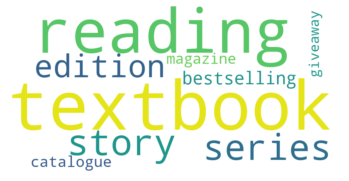

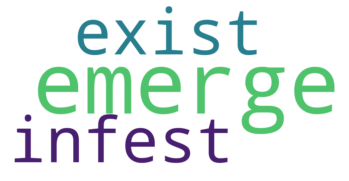

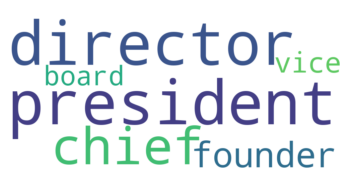

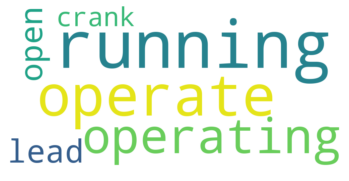

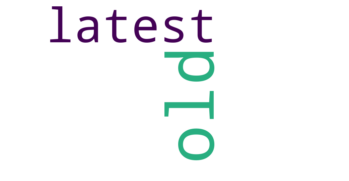

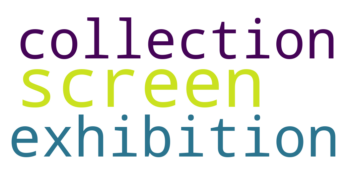

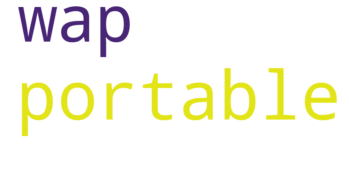

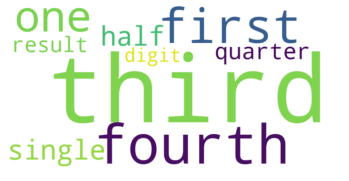

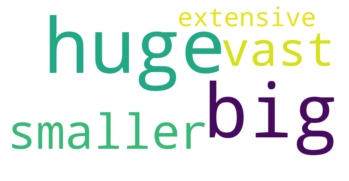

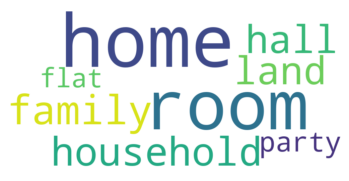

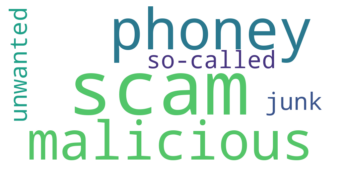

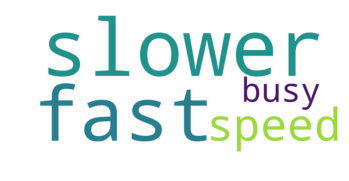

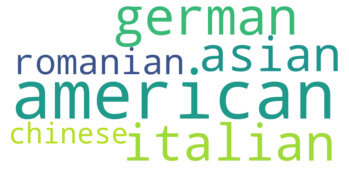

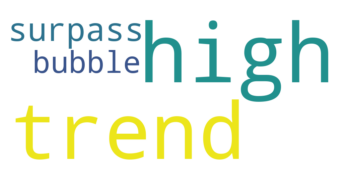

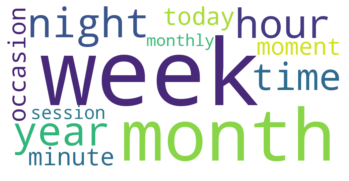

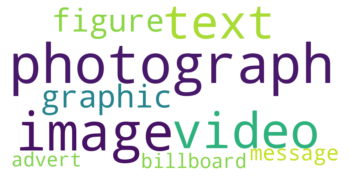

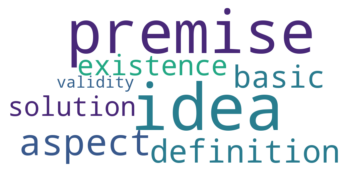

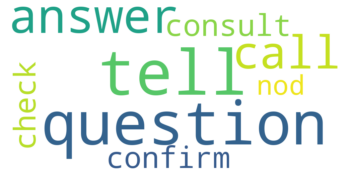

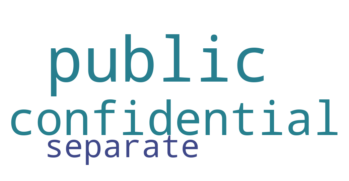

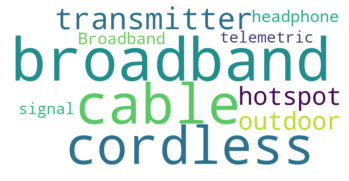

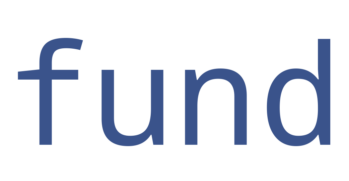

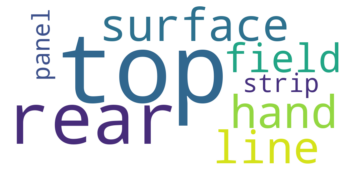

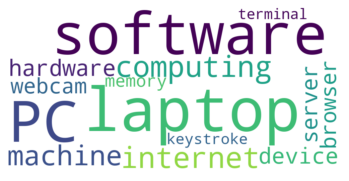

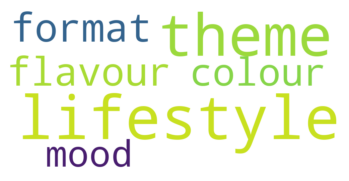

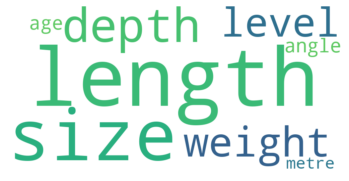

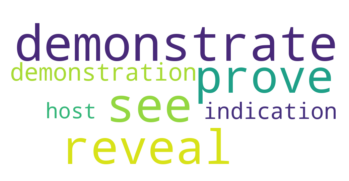

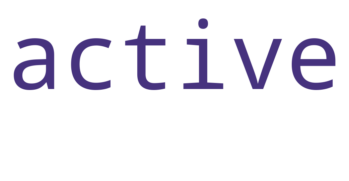

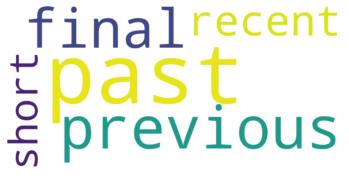

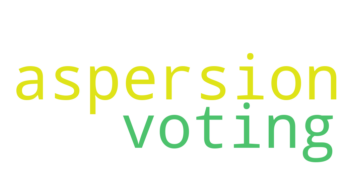

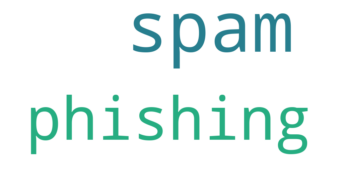

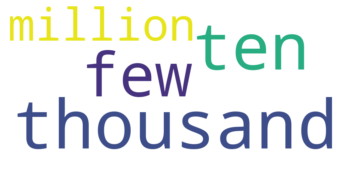

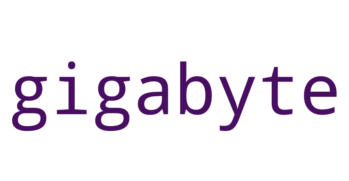

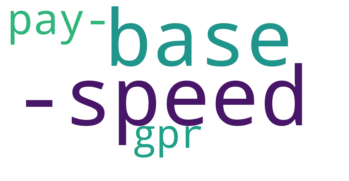

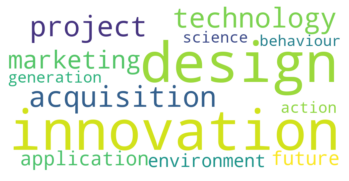

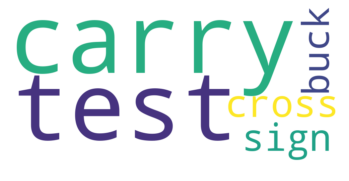

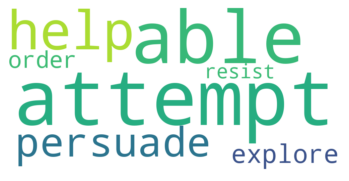

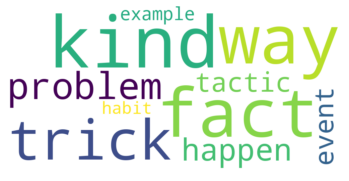

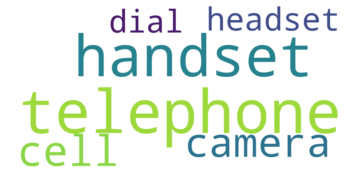

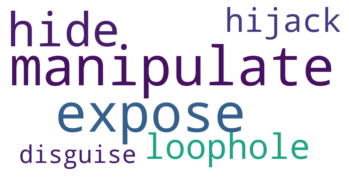

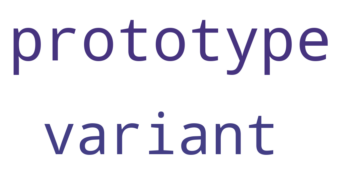

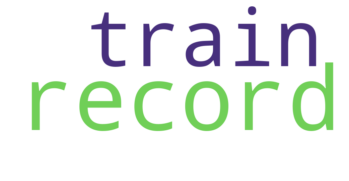

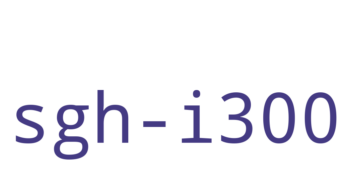

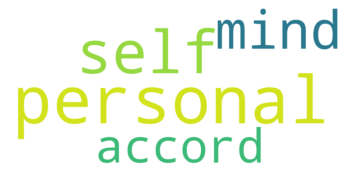

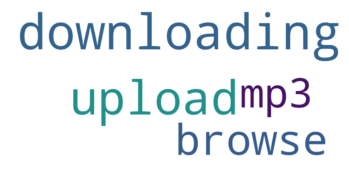

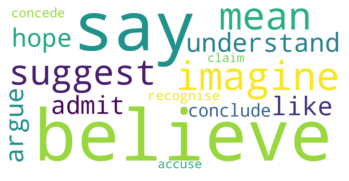

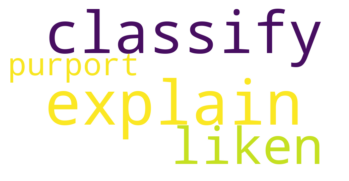

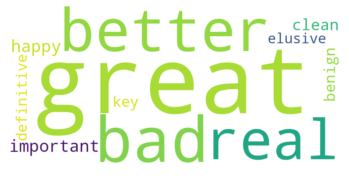

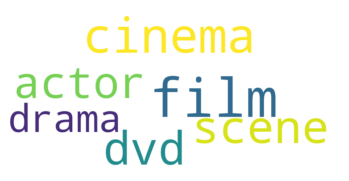

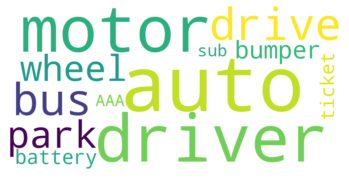

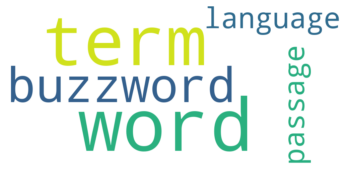

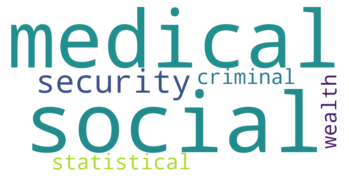

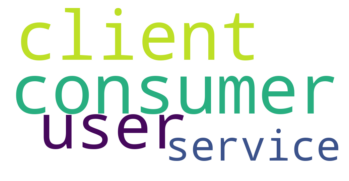

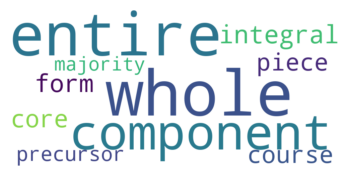

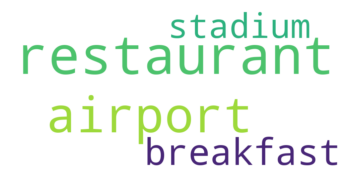

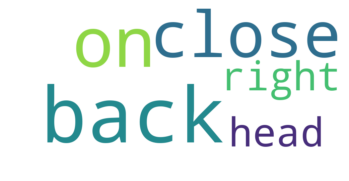

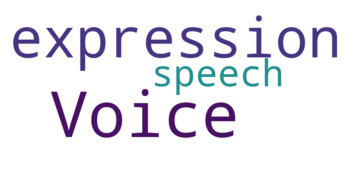

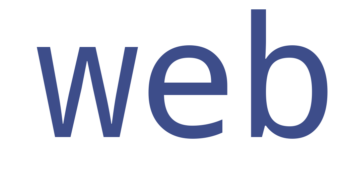

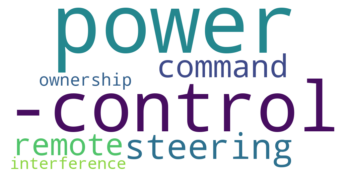

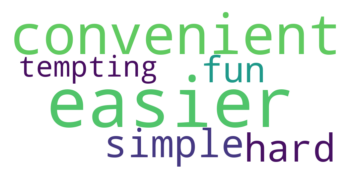

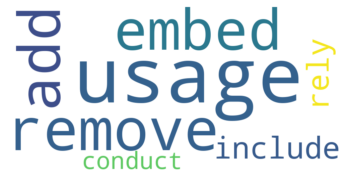

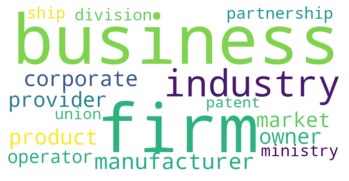

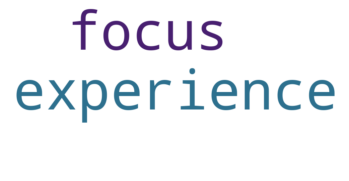

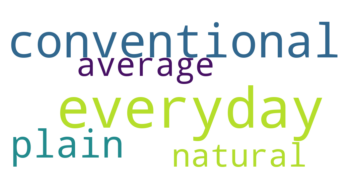

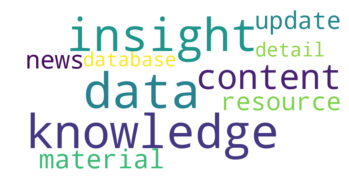

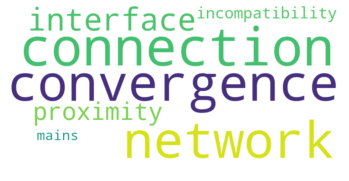

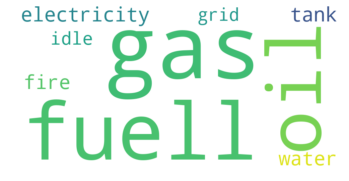

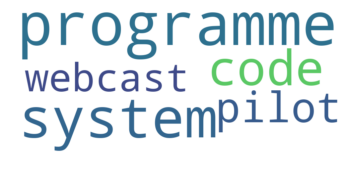

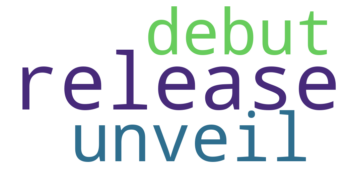

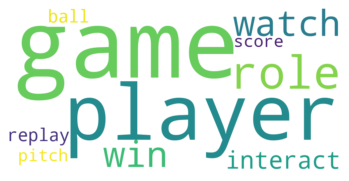

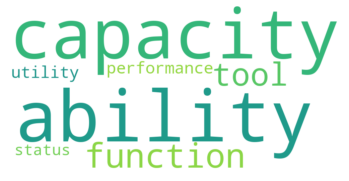

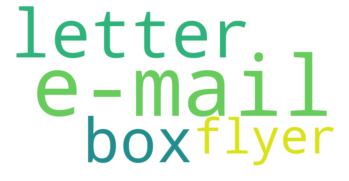

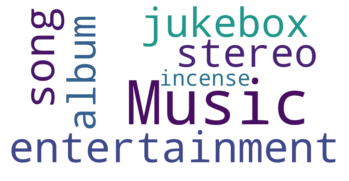

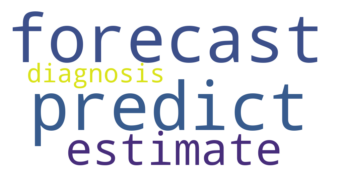

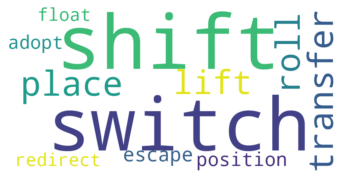

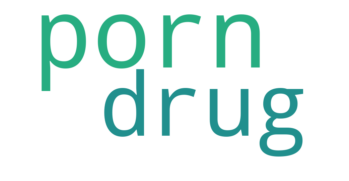

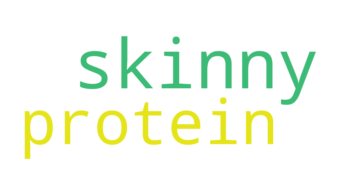

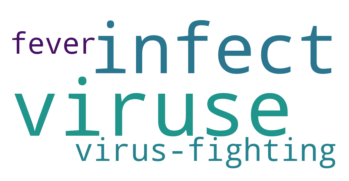

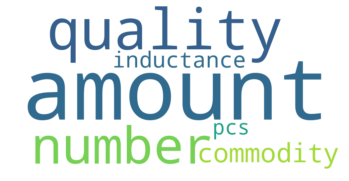

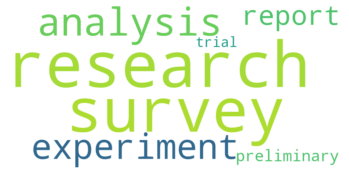

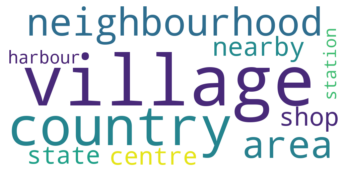

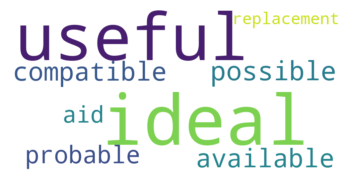

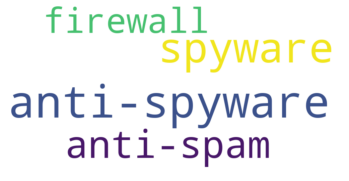

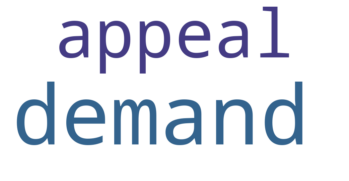

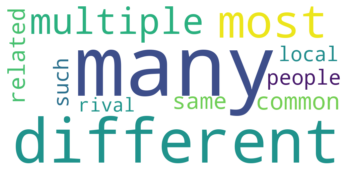

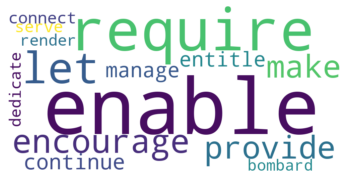

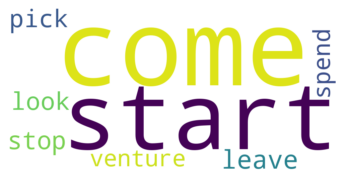

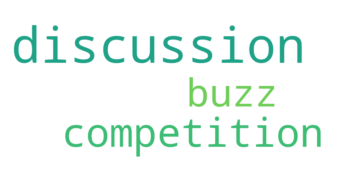

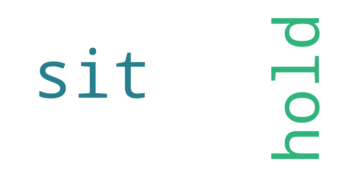

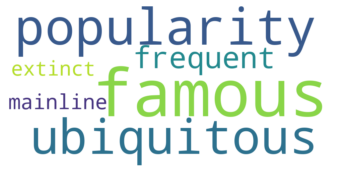

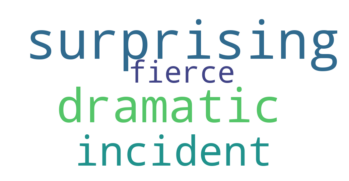

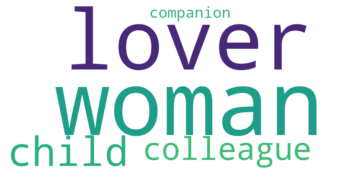

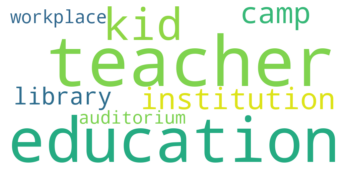

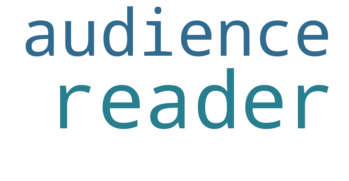

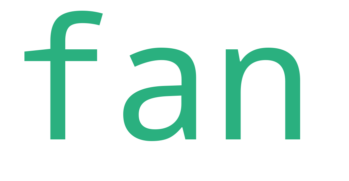

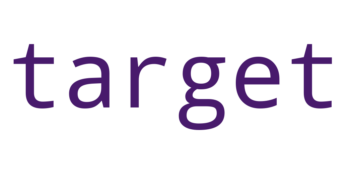

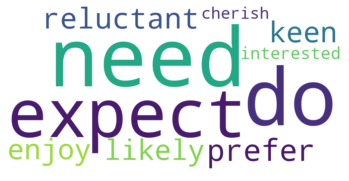

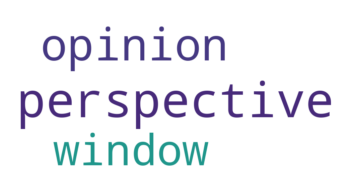

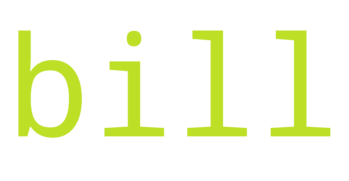

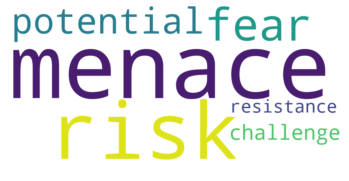

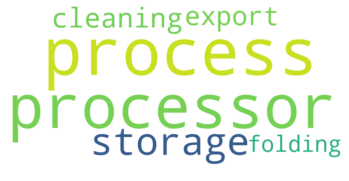

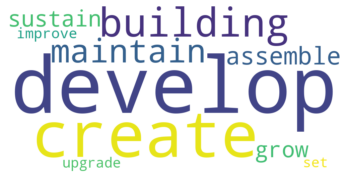

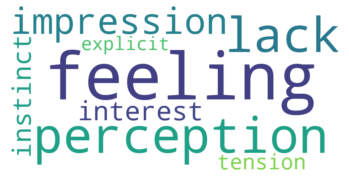

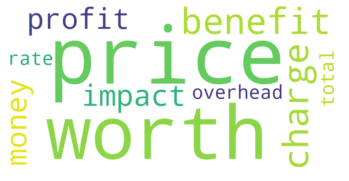

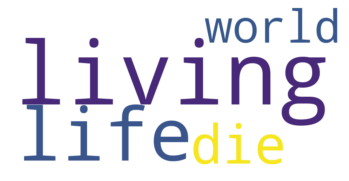

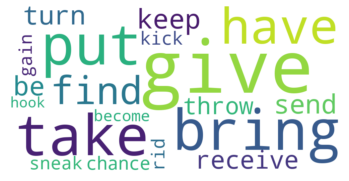

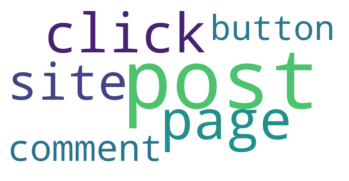

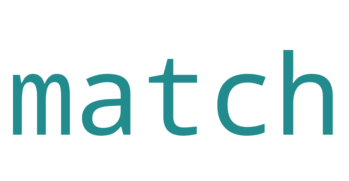

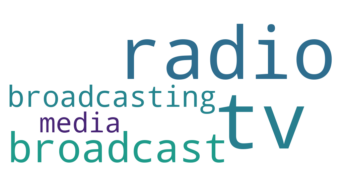

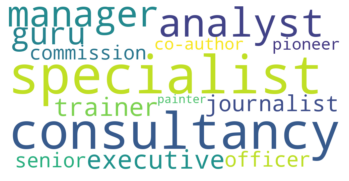

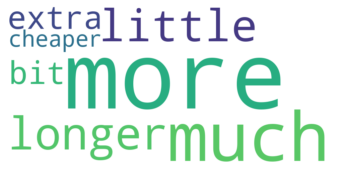

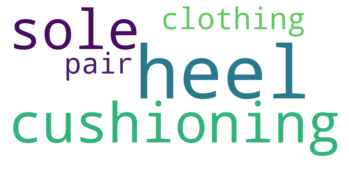

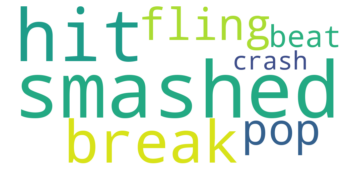

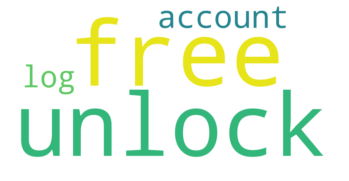

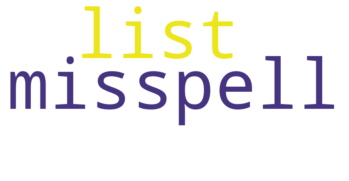

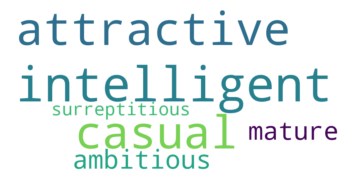

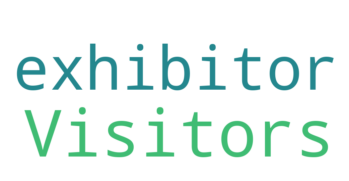

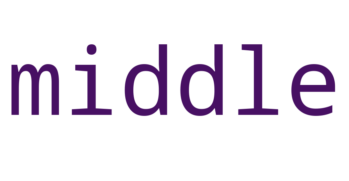

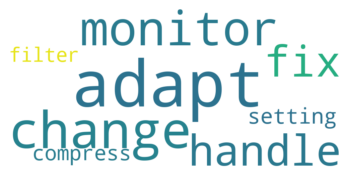

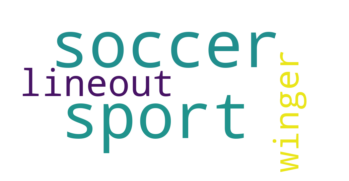

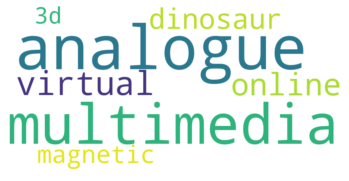

In [34]:
# producing wordclouds 
for k, v in ret.items():
    try:
        wc = WordCloud(
            background_color="white",
            width=1000,
            height=500,
        )
        wc.generate_from_frequencies(v)
        # plot wordcloud
        plt.axis("off")
        plt.imshow(wc, interpolation="bilinear")
        plt.show()
    
    except ValueError:
        pass